In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# === Load both datasets ===

dfs_parallel = {i: pd.read_csv(f"halpha_results_Z/SB{i}_halpha_results.csv") for i in range(1,8)}

In [3]:
colors = plt.cm.tab10.colors  # 10 distinct colors
color_map = {i: colors[i-1] for i in range(1, 8)}

In [4]:
center_pixels = {
    1: 190,
    2: 192,
    3: 195,
    4: 192,
    5: 192,
    6: 194,
    7: 189,}

center_pixels_orth = {
    1: 193,
    2: 188,
    3: 190,
    4: 187,
    5: 184,
    6: 186,
    7: 189,}

bar_lengths = {
    1: 13.26115798,
    2: 7.801902515,
    3: 5.863607675,
    4: 5.392712855,
    5: 8.840541595,
    6: 5.72536702,
    7: 6.06715746,
}


In [5]:
def weighted_mean(values, errors, mask):
    vals  = values[mask]
    errs  = errors[mask]
    if np.any(mask) and np.all(errs > 0):
        weights = 1 / errs**2
        mean = np.sum(weights * vals) / np.sum(weights)
        mean_err = np.sqrt(1 / np.sum(weights))
        return mean, mean_err
    return np.nan, np.nan


In [6]:
def summarize_regions(dfs, center_pixels, bar_lengths, take_abs_velocity=True):
    rows = []
    for i, df in dfs.items():
        if i not in center_pixels or i not in bar_lengths:
            continue
        x_rel = (df["center"] - center_pixels[i]) * 0.4  # arcsec
        x_scaled = x_rel / bar_lengths[i]
        abs_x = np.abs(x_scaled)

        center_mask = (abs_x < 0.3)
        bar_mask    = (abs_x >= 0.3) & (abs_x < 0.8)
        out_mask    = (abs_x >= 0.8) & (abs_x <= 1.2)

        vel = np.abs(df["velocity"]) if take_abs_velocity else df["velocity"]

        v_c, v_c_err = weighted_mean(vel, df["velocity_err"], center_mask)
        v_b, v_b_err = weighted_mean(vel, df["velocity_err"], bar_mask)
        v_o, v_o_err = weighted_mean(vel, df["velocity_err"], out_mask)

        s_c, s_c_err = weighted_mean(df["dispersion"], df["dispersion_err"], center_mask)
        s_b, s_b_err = weighted_mean(df["dispersion"], df["dispersion_err"], bar_mask)
        s_o, s_o_err = weighted_mean(df["dispersion"], df["dispersion_err"], out_mask)

        ew_c, ew_c_err = weighted_mean(df["EW"], df["EW_err"], center_mask)
        ew_b, ew_b_err = weighted_mean(df["EW"], df["EW_err"], bar_mask)
        ew_o, ew_o_err = weighted_mean(df["EW"], df["EW_err"], out_mask)

        rows.append({
            "WB": i,
            "v_center": v_c, "v_center_err": v_c_err,
            "v_bar":    v_b, "v_bar_err":    v_b_err,
            "v_out":    v_o, "v_out_err":    v_o_err,
            "σ_center": s_c, "σ_center_err": s_c_err,
            "σ_bar":    s_b, "σ_bar_err":    s_b_err,
            "σ_out":    s_o, "σ_out_err":    s_o_err,
            "EW_center": ew_c, "EW_center_err": ew_c_err,
            "EW_bar":    ew_b, "EW_bar_err":    ew_b_err,
            "EW_out":    ew_o, "EW_out_err":    ew_o_err,
        })
    return pd.DataFrame(rows)


In [8]:
summary_parallel   = summarize_regions(dfs_parallel, center_pixels,      bar_lengths, take_abs_velocity=True)
#summary_orthogonal = summarize_regions(dfs_orth,     center_pixels_orth, bar_lengths, take_abs_velocity=True)

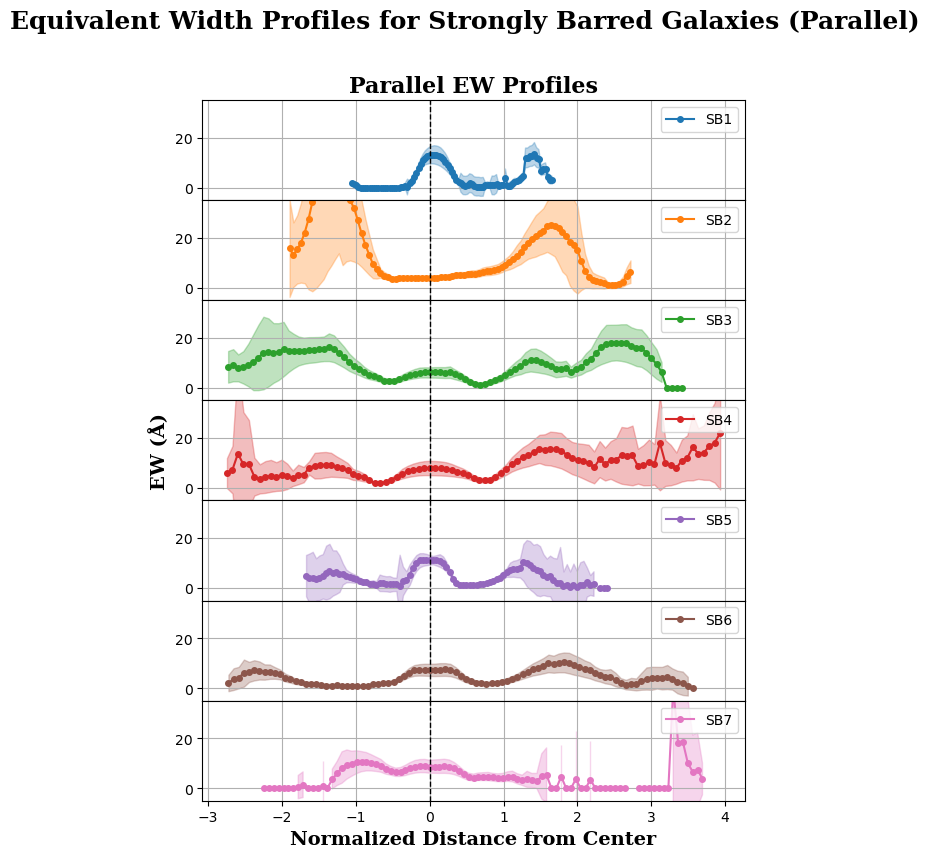

In [17]:
fig, axs = plt.subplots(len(dfs_parallel), 1, figsize=(7, 1.3*len(dfs_parallel)), sharex=True)

# Keep structure consistent if only one row
if len(dfs_parallel) == 1:
    axs = [axs]

for row_idx, i in enumerate(dfs_parallel.keys()):
    df_p = dfs_parallel[i]
    x_rel_p = (df_p["center"] - center_pixels[i]) * 0.4
    x_scaled_p = x_rel_p / bar_lengths[i]
    
    axs[row_idx].plot(x_scaled_p, df_p["EW"], "o-", color=color_map[i], label=f"SB{i}", ms=4)
    axs[row_idx].fill_between(
        x_scaled_p,
        df_p["EW"] - df_p["EW_err"],
        df_p["EW"] + df_p["EW_err"],
        color=color_map[i],
        alpha=0.3
    )
    axs[row_idx].set_ylim(-5, 35)
    axs[row_idx].axvline(0, color="black", ls="--", lw=1)
    axs[row_idx].grid(True)
    axs[row_idx].legend(loc="upper right", fontsize=10)

# Title for the whole figure
axs[0].set_title("Parallel EW Profiles", fontsize=16, fontweight="bold", family="serif")

# Axis labels
axs[-1].set_xlabel("Normalized Distance from Center", fontsize=14, fontweight="bold", family="serif")
axs[len(dfs_parallel)//2].set_ylabel("EW (Å)", fontsize=14, fontweight="bold", family="serif")

plt.suptitle(
    "Equivalent Width Profiles for Strongly Barred Galaxies (Parallel)",
    fontsize=18,
    fontweight="bold",
    family="serif"
)

plt.subplots_adjust(hspace=0.0)
plt.show()


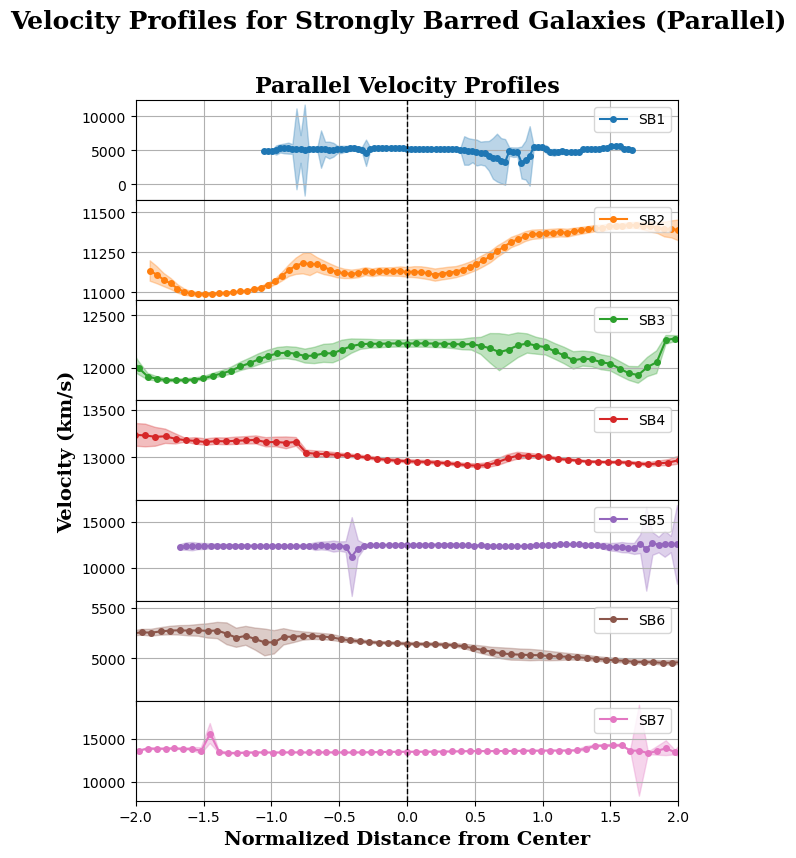

In [22]:
fig, axs = plt.subplots(len(dfs_parallel), 1, figsize=(7, 1.3*len(dfs_parallel)), sharex=True)

if len(dfs_parallel) == 1:
    axs = [axs]  # Keep consistent structure

for row_idx, i in enumerate(dfs_parallel.keys()):
    df_p = dfs_parallel[i]
    x_rel_p = (df_p["center"] - center_pixels[i]) * 0.4
    x_scaled_p = x_rel_p / bar_lengths[i]
    
    axs[row_idx].plot(x_scaled_p, df_p["velocity"], "o-", color=color_map[i], label=f"SB{i}", ms=4)
    axs[row_idx].fill_between(
        x_scaled_p,
        df_p["velocity"] - df_p["velocity_err"],
        df_p["velocity"] + df_p["velocity_err"],
        color=color_map[i],
        alpha=0.3
    )
    #axs[row_idx].set_ylim(10000, 15000)
    axs[row_idx].set_xlim(-2, 2)
    axs[row_idx].axvline(0, color="black", ls="--", lw=1)
    axs[row_idx].grid(True)
    axs[row_idx].legend(loc="upper right", fontsize=10)

# Column title
axs[0].set_title("Parallel Velocity Profiles", fontsize=16, fontweight="bold", family="serif")

# Axis labels
axs[-1].set_xlabel("Normalized Distance from Center", fontsize=14, fontweight="bold", family="serif")
axs[len(dfs_parallel)//2].set_ylabel("Velocity (km/s)", fontsize=14, fontweight="bold", family="serif")

# Overall title
plt.suptitle(
    "Velocity Profiles for Strongly Barred Galaxies (Parallel)",
    fontsize=18,
    fontweight="bold",
    family="serif"
)

plt.subplots_adjust(hspace=0.0)
plt.show()


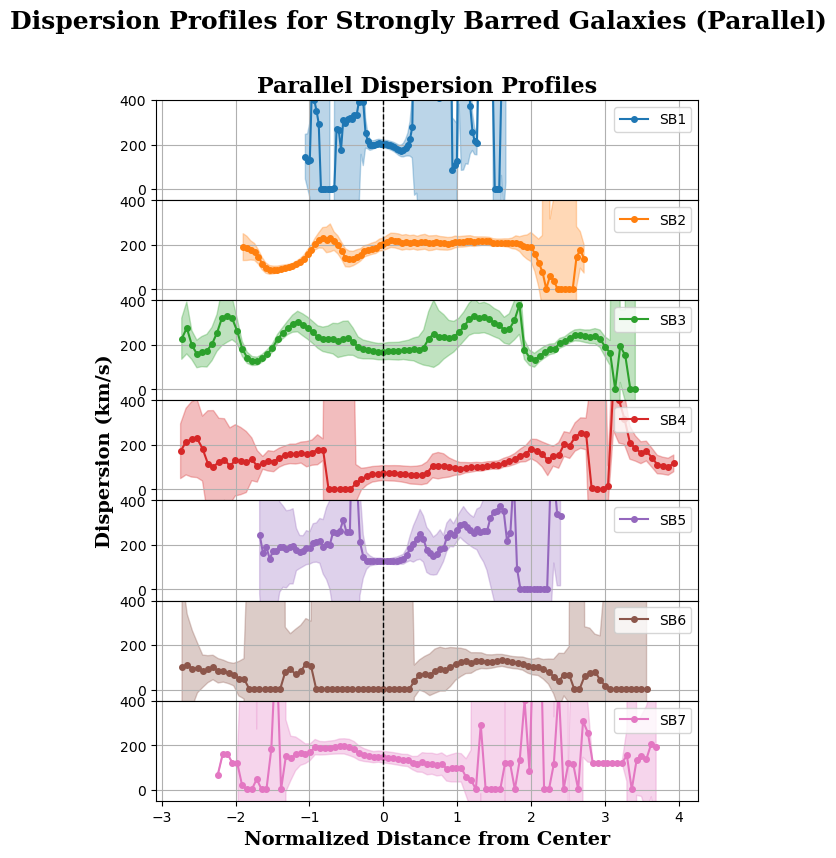

In [23]:
fig, axs = plt.subplots(len(dfs_parallel), 1, figsize=(7, 1.3*len(dfs_parallel)), sharex=True, sharey=True)

if len(dfs_parallel) == 1:
    axs = [axs]  # Keep consistent structure

for row_idx, i in enumerate(dfs_parallel.keys()):
    df_p = dfs_parallel[i]
    x_rel_p = (df_p["center"] - center_pixels[i]) * 0.4
    x_scaled_p = x_rel_p / bar_lengths[i]
    
    axs[row_idx].plot(x_scaled_p, df_p["dispersion"], "o-", color=color_map[i], label=f"SB{i}", ms=4)
    axs[row_idx].fill_between(
        x_scaled_p,
        df_p["dispersion"] - df_p["dispersion_err"],
        df_p["dispersion"] + df_p["dispersion_err"],
        color=color_map[i],
        alpha=0.3
    )
    axs[row_idx].set_ylim(-50, 400)
    axs[row_idx].axvline(0, color="black", ls="--", lw=1)
    axs[row_idx].grid(True)
    axs[row_idx].legend(loc="upper right", fontsize=10)

# Title
axs[0].set_title("Parallel Dispersion Profiles", fontsize=16, fontweight="bold", family="serif")

# Axis labels
axs[-1].set_xlabel("Normalized Distance from Center", fontsize=14, fontweight="bold", family="serif")
axs[len(dfs_parallel)//2].set_ylabel("Dispersion (km/s)", fontsize=14, fontweight="bold", family="serif")

# Overall title
plt.suptitle(
    "Dispersion Profiles for Strongly Barred Galaxies (Parallel)",
    fontsize=18,
    fontweight="bold",
    family="serif"
)

plt.subplots_adjust(hspace=0.0)
plt.show()


NameError: name 'dfs_orth' is not defined

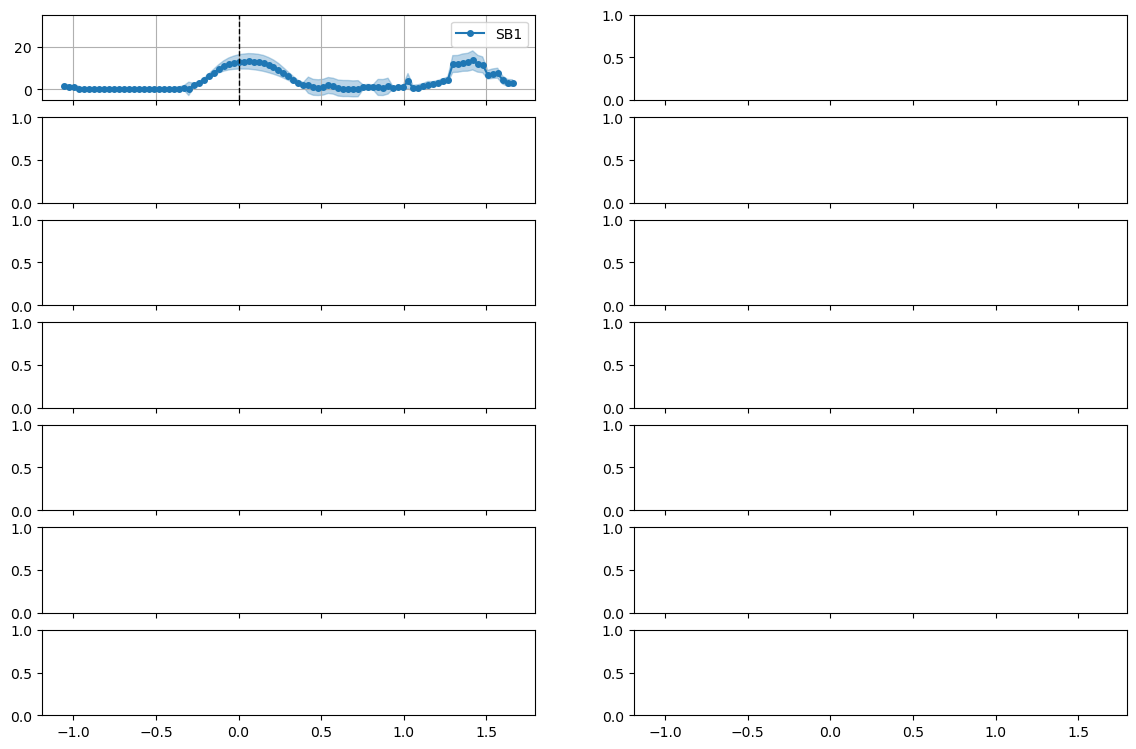

In [16]:
fig, axs = plt.subplots(len(dfs_parallel), 2, figsize=(14, 1.3*len(dfs_parallel)), sharex=True)

if len(dfs_parallel) == 1:
    axs = [axs]  # Keep consistent structure

for row_idx, i in enumerate(dfs_parallel.keys()):
    # --- Parallel ---
    df_p = dfs_parallel[i]
    x_rel_p = (df_p["center"] - center_pixels[i]) * 0.4
    x_scaled_p = x_rel_p / bar_lengths[i]
    
    axs[row_idx, 0].plot(x_scaled_p, df_p["EW"], "o-", color=color_map[i], label=f"SB{i}", ms=4)
    axs[row_idx, 0].fill_between(
        x_scaled_p,
        df_p["EW"] - df_p["EW_err"],
        df_p["EW"] + df_p["EW_err"],
        color=color_map[i],
        alpha=0.3
    )
    axs[row_idx, 0].set_ylim(-5, 35)
    axs[row_idx, 0].axvline(0, color="black", ls="--", lw=1)
    axs[row_idx, 0].grid(True)
    axs[row_idx, 0].legend(loc="upper right", fontsize=10)

    # --- Orthogonal ---
    df_o = dfs_orth[i]
    x_rel_o = (df_o["center"] - center_pixels_orth[i]) * 0.4
    x_scaled_o = x_rel_o / bar_lengths[i]
    
    axs[row_idx, 1].plot(x_scaled_o, df_o["EW"], "o-", color=color_map[i], label=f"SB{i}", ms=4)
    axs[row_idx, 1].fill_between(
        x_scaled_o,
        df_o["EW"] - df_o["EW_err"],
        df_o["EW"] + df_o["EW_err"],
        color=color_map[i],
        alpha=0.3
    )
    axs[row_idx, 1].set_ylim(-5, 35)
    axs[row_idx, 1].set_xlim(-4,4)
    axs[row_idx, 1].axvline(0, color="black", ls="--", lw=1)
    axs[row_idx, 1].grid(True)
    axs[row_idx, 1].legend(loc="upper right", fontsize=10)

# Column titles – larger, bold, and easy to read from a distance
axs[0, 0].set_title("Parallel EW Profile", fontsize=16, fontweight="bold", family="serif")
axs[0, 1].set_title("Orthogonal EW Profile", fontsize=16, fontweight="bold", family="serif")

# Axis labels – also bolder and larger than default
for ax in axs[-1, :]:
    ax.set_xlabel("Normalized Distance from Center", fontsize=14, fontweight="bold", family="serif")

axs[len(dfs_parallel)//2, 0].set_ylabel("EW (Å)", fontsize=14, fontweight="bold", family="serif")

# Overall title – large and bold for poster readability
plt.suptitle(
    "Equivalent Width Profiles for Strongly Barred Galaxies",
    fontsize=18,
    fontweight="bold",
    family="serif"
)

# Adjust spacing so titles aren’t cramped
plt.subplots_adjust(hspace=0, wspace=0.08)
plt.show()


In [ ]:
fig, axs = plt.subplots(len(dfs_parallel), 2, figsize=(14, 1.3*len(dfs_parallel)), sharex=True)

if len(dfs_parallel) == 1:
    axs = [axs]

for row_idx, i in enumerate(dfs_parallel.keys()):
    # --- Parallel ---
    df_p = dfs_parallel[i]
    x_rel_p = (df_p["center"] - center_pixels[i]) * 0.4
    x_scaled_p = x_rel_p / bar_lengths[i]
    
    axs[row_idx, 0].plot(x_scaled_p, df_p["velocity"], "o-", color=color_map[i], label=f"SB{i}", ms=4)
    axs[row_idx, 0].fill_between(
        x_scaled_p,
        df_p["velocity"] - df_p["velocity_err"],
        df_p["velocity"] + df_p["velocity_err"],
        color=color_map[i],
        alpha=0.3
    )
    axs[row_idx, 0].set_ylim(-400, 400)
    axs[row_idx, 0].set_xlim(-2, 2)
    axs[row_idx, 0].axvline(0, color="black", ls="--", lw=1)
    axs[row_idx, 0].grid(True)
    axs[row_idx, 0].legend(loc="upper right", fontsize=10)

    # --- Orthogonal ---
    df_o = dfs_orth[i]
    x_rel_o = (df_o["center"] - center_pixels_orth[i]) * 0.4
    x_scaled_o = x_rel_o / bar_lengths[i]
    
    axs[row_idx, 1].plot(x_scaled_o, df_o["velocity"], "o-", color=color_map[i], label=f"SB{i}", ms=4)  # added label
    axs[row_idx, 1].fill_between(
        x_scaled_o,
        df_o["velocity"] - df_o["velocity_err"],
        df_o["velocity"] + df_o["velocity_err"],
        color=color_map[i],
        alpha=0.3
    )
    axs[row_idx, 1].legend(loc="upper right", fontsize=10)
    axs[row_idx, 1].set_ylim(-400, 400)
    axs[row_idx, 1].set_xlim(-2, 2)
    axs[row_idx, 1].axvline(0, color="black", ls="--", lw=1)
    axs[row_idx, 1].grid(True)


# Column titles – larger, bold, and easy to read from a distance
axs[0, 0].set_title("Parallel Velocity Profile", fontsize=16, fontweight="bold", family="serif")
axs[0, 1].set_title("Orthogonal Velocity Profile", fontsize=16, fontweight="bold", family="serif")

# Axis labels – also bolder and larger than default
for ax in axs[-1, :]:
    ax.set_xlabel("Normalized Distance from Center", fontsize=14, fontweight="bold", family="serif")

axs[len(dfs_parallel)//2, 0].set_ylabel("Velocity (km/s)", fontsize=14, fontweight="bold", family="serif")

# Overall title – large and bold for poster readability
plt.suptitle(
    "Velocity Profiles for Strongly Barred Galaxies",
    fontsize=18,
    fontweight="bold",
    family="serif"
)

# Adjust spacing so plots touch vertically and have minimal horizontal gap
plt.subplots_adjust(hspace=0, wspace=0.1)
plt.show()


In [ ]:
fig, axs = plt.subplots(len(dfs_parallel), 2, figsize=(14, 1.3*len(dfs_parallel)), sharex=True, sharey=True)

if len(dfs_parallel) == 1:
    axs = [axs]

for row_idx, i in enumerate(dfs_parallel.keys()):
    # --- Parallel ---
    df_p = dfs_parallel[i]
    x_rel_p = (df_p["center"] - center_pixels[i]) * 0.4
    x_scaled_p = x_rel_p / bar_lengths[i]
    
    axs[row_idx, 0].plot(x_scaled_p, df_p["dispersion"], "o-", color=color_map[i], label=f"SB{i}", ms=4)
    axs[row_idx, 0].fill_between(
        x_scaled_p,
        df_p["dispersion"] - df_p["dispersion_err"],
        df_p["dispersion"] + df_p["dispersion_err"],
        color=color_map[i],
        alpha=0.3
    )
    axs[row_idx, 0].set_ylim(-50, 400)
    axs[row_idx, 0].axvline(0, color="black", ls="--", lw=1)
    axs[row_idx, 0].grid(True)
    axs[row_idx, 0].legend(loc="upper right", fontsize=10)

    # --- Orthogonal ---
    df_o = dfs_orth[i]
    x_rel_o = (df_o["center"] - center_pixels_orth[i]) * 0.4
    x_scaled_o = x_rel_o / bar_lengths[i]
    
    axs[row_idx, 1].plot(x_scaled_o, df_o["dispersion"], "o-", color=color_map[i], label=f"SB{i}", ms=4)
    axs[row_idx, 1].fill_between(
        x_scaled_o,
        df_o["dispersion"] - df_o["dispersion_err"],
        df_o["dispersion"] + df_o["dispersion_err"],
        color=color_map[i],
        alpha=0.3
    )
    axs[row_idx, 1].set_ylim(-50, 400)
    axs[row_idx, 1].axvline(0, color="black", ls="--", lw=1)
    axs[row_idx, 1].grid(True)
    axs[row_idx, 1].legend(loc="upper right", fontsize=10)

# Column titles – match style
axs[0, 0].set_title("Parallel Dispersion Profile", fontsize=16, fontweight="bold", family="serif")
axs[0, 1].set_title("Orthogonal Dispersion Profile", fontsize=16, fontweight="bold", family="serif")

# X-axis labels – match style
for ax in axs[-1, :]:
    ax.set_xlabel("Normalized Distance from Center", fontsize=14, fontweight="bold", family="serif")

# Y-axis label – match style
axs[len(dfs_parallel)//2, 0].set_ylabel("Dispersion (km/s)", fontsize=14, fontweight="bold", family="serif")

# Overall title – match style
plt.suptitle(
    "Dispersion Profiles for Strongly Barred Galaxies",
    fontsize=18,
    fontweight="bold",
    family="serif"
)

# Spacing – match style
plt.subplots_adjust(hspace=0, wspace=0.08)
plt.show()
